In [1]:
"""
    Experimentation with a custom neural network on a datset of MRI covid/non-covid images.
    
    Created: 9/21 (Akarsh V Hebbar)
    
    
    Potential source of getting all layer predictions: https://stackoverflow.com/questions/51677631/keras-tensorflow-get-predictions-or-output-of-all-layers-efficiently

"""

import cv2, random
import numpy as np
import matplotlib.pyplot as plt
import keract

import tensorflow as tf
from tensorflow.keras.layers import *
from keract import get_activations, display_heatmaps, display_activations
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras import activations

from DataHandler import dataHandler


In [2]:
dh = dataHandler() # data handler object. See DataHandler.py for more information.

# ALTER HYPERPARAMETERS HERE
BATCH_SIZE = 512




In [3]:
dataset = dh.get_all_data_labeled(shuffle=True)

In [4]:
# check that all data is in place
assert len(dh.get_non_covid_data_fp()) == 397 and len(dh.get_covid_data_fp()) == 326 and len(dh.get_all_data_labeled()) == (397 + 326)

In [5]:
datapoint = dataset[0] # get some datapoint from the dataset
random_img = cv2.imread(datapoint[0])

Label:  0.0
filepath:  C:\Users\Akarsh\CSCI-8860\data\CT_NonCOVID\5%2.jpg
image dimensions:  (108, 139, 3)
image datatype:  uint8
image max:  255
image min


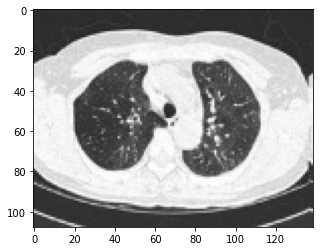

In [6]:
print("Label: ", datapoint[1])
print("filepath: ", datapoint[0])
print("image dimensions: ", random_img.shape)
print("image datatype: ", random_img.dtype)
print("image max: ", random_img.max())
print("image min")
plt.imshow(random_img)

In [7]:
# split the dataset into a train and test dataset

split_point = int(len(dataset) * .8 ) # 80 / 20 split

train_data = dataset[0:split_point]
test_data = dataset[split_point:]

assert len(train_data) + len(test_data) == (397 + 326) # ensure all expected data is present

train_data = train_data + train_data + train_data + train_data + train_data + train_data # when using the noise adder and random rotation then triple the datasets
random.shuffle(train_data)

In [8]:
# get the image data and load it into memory


train_X = np.asarray([dh.load_image(fp, resize=True, add_noise=False, randomly_rotate=False, grayscale=True) for (fp, label) in train_data]).astype('uint8')
train_y = np.asarray([label for (fp, label) in train_data]).astype('float16')

test_X = np.asarray([dh.load_image(fp, resize=True, add_noise=False, randomly_rotate=False, grayscale=True) for (fp, label) in test_data]).astype('uint8')
test_y = np.asarray([np.asarray(label) for (fp, label) in test_data]).astype('float16')

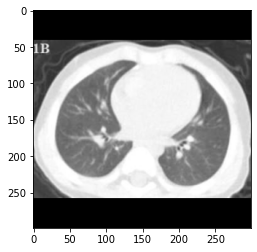

In [9]:
plt.imshow(train_X[0], cmap='gray')

In [10]:
#assert False

In [11]:
i = Input((299,299,3))
x = Conv2D(16, (4,4), strides=(4,4), padding='valid', activation='relu')(i)
x = BatchNormalization()(x)
#x = Conv2D(16, (4,4), strides=(4,4), padding='valid', activation='relu')(x)
#x = BatchNormalization()(x)
#x = Conv2D(32, (3,3), strides=(3,3), padding='valid', activation='relu')(x)
#x = BatchNormalization()(x)

# change filter dim back to 32 for 80% accuracy
x = Conv2D(32, (3,3), strides=(3,3), padding='valid', activation='relu')(x)
x = Dropout(0.2)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu', dtype=tf.float32)(x)
x = Dropout(0.5)(x)
prediction = Dense(1, activation='sigmoid', dtype=tf.float32)(x)


model = tf.keras.Model(inputs=i,outputs=prediction)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.BinaryAccuracy(),)





In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 74, 74, 16)        784       
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)               

In [13]:
history = model.fit(x=train_X, y=train_y, batch_size=BATCH_SIZE, validation_data=(test_X, test_y), epochs=1000, )

Epoch 1/1000
7/7 [==============================] - 9s 1s/step - loss: 0.6949 - binary_accuracy: 0.5187 - val_loss: 0.8669 - val_binary_accuracy: 0.3724
Epoch 2/1000
7/7 [==============================] - 8s 1s/step - loss: 0.6788 - binary_accuracy: 0.5649 - val_loss: 1.0284 - val_binary_accuracy: 0.3724
Epoch 3/1000
7/7 [==============================] - 8s 1s/step - loss: 0.6725 - binary_accuracy: 0.5741 - val_loss: 1.2301 - val_binary_accuracy: 0.3724
Epoch 4/1000
7/7 [==============================] - 8s 1s/step - loss: 0.6667 - binary_accuracy: 0.5917 - val_loss: 1.0520 - val_binary_accuracy: 0.3724
Epoch 5/1000
7/7 [==============================] - 8s 1s/step - loss: 0.6619 - binary_accuracy: 0.5877 - val_loss: 1.0209 - val_binary_accuracy: 0.3793
Epoch 6/1000
7/7 [==============================] - 8s 1s/step - loss: 0.6581 - binary_accuracy: 0.5928 - val_loss: 0.8384 - val_binary_accuracy: 0.3931
Epoch 7/1000
7/7 [==============================] - 9s 1s/step - loss: 0.6494 - bi

7/7 [==============================] - 8s 1s/step - loss: 0.5252 - binary_accuracy: 0.7252 - val_loss: 1.5510 - val_binary_accuracy: 0.3793
Epoch 55/1000
7/7 [==============================] - 8s 1s/step - loss: 0.4920 - binary_accuracy: 0.7396 - val_loss: 1.5650 - val_binary_accuracy: 0.3793
Epoch 56/1000
7/7 [==============================] - 7s 1s/step - loss: 0.4846 - binary_accuracy: 0.7529 - val_loss: 2.0369 - val_binary_accuracy: 0.3793
Epoch 57/1000
7/7 [==============================] - 8s 1s/step - loss: 0.4703 - binary_accuracy: 0.7641 - val_loss: 1.5382 - val_binary_accuracy: 0.3862
Epoch 58/1000
7/7 [==============================] - 7s 1s/step - loss: 0.4638 - binary_accuracy: 0.7670 - val_loss: 1.2639 - val_binary_accuracy: 0.4483
Epoch 59/1000
7/7 [==============================] - 8s 1s/step - loss: 0.4638 - binary_accuracy: 0.7673 - val_loss: 0.9596 - val_binary_accuracy: 0.5241
Epoch 60/1000
7/7 [==============================] - 8s 1s/step - loss: 0.4546 - binary_ac

7/7 [==============================] - 8s 1s/step - loss: 0.3844 - binary_accuracy: 0.8408 - val_loss: 0.6323 - val_binary_accuracy: 0.7310
Epoch 108/1000
7/7 [==============================] - 7s 1s/step - loss: 0.3744 - binary_accuracy: 0.8385 - val_loss: 0.6047 - val_binary_accuracy: 0.7724
Epoch 109/1000
7/7 [==============================] - 7s 1s/step - loss: 0.3777 - binary_accuracy: 0.8310 - val_loss: 0.6620 - val_binary_accuracy: 0.7172
Epoch 110/1000
7/7 [==============================] - 7s 1s/step - loss: 0.3719 - binary_accuracy: 0.8391 - val_loss: 0.6341 - val_binary_accuracy: 0.7379
Epoch 111/1000
7/7 [==============================] - 7s 1s/step - loss: 0.3648 - binary_accuracy: 0.8423 - val_loss: 0.6344 - val_binary_accuracy: 0.7517
Epoch 112/1000
7/7 [==============================] - 7s 1s/step - loss: 0.3630 - binary_accuracy: 0.8417 - val_loss: 0.6401 - val_binary_accuracy: 0.7241
Epoch 113/1000
7/7 [==============================] - 8s 1s/step - loss: 0.3744 - bin

Epoch 160/1000
7/7 [==============================] - 7s 1s/step - loss: 0.3368 - binary_accuracy: 0.8573 - val_loss: 0.6813 - val_binary_accuracy: 0.7586
Epoch 161/1000
7/7 [==============================] - 8s 1s/step - loss: 0.3280 - binary_accuracy: 0.8702 - val_loss: 0.6367 - val_binary_accuracy: 0.7448
Epoch 162/1000
7/7 [==============================] - 8s 1s/step - loss: 0.3328 - binary_accuracy: 0.8535 - val_loss: 0.8099 - val_binary_accuracy: 0.7310
Epoch 163/1000
7/7 [==============================] - 8s 1s/step - loss: 0.3280 - binary_accuracy: 0.8550 - val_loss: 0.7347 - val_binary_accuracy: 0.7793
Epoch 164/1000
7/7 [==============================] - 7s 1s/step - loss: 0.3239 - binary_accuracy: 0.8691 - val_loss: 0.8945 - val_binary_accuracy: 0.6690
Epoch 165/1000
7/7 [==============================] - 8s 1s/step - loss: 0.3229 - binary_accuracy: 0.8596 - val_loss: 0.6963 - val_binary_accuracy: 0.7517
Epoch 166/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 213/1000
7/7 [==============================] - 7s 1s/step - loss: 0.2821 - binary_accuracy: 0.8858 - val_loss: 0.9749 - val_binary_accuracy: 0.7172
Epoch 214/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2878 - binary_accuracy: 0.8849 - val_loss: 0.8106 - val_binary_accuracy: 0.7379
Epoch 215/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2758 - binary_accuracy: 0.8922 - val_loss: 0.7856 - val_binary_accuracy: 0.7034
Epoch 216/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2817 - binary_accuracy: 0.8864 - val_loss: 0.8598 - val_binary_accuracy: 0.7379
Epoch 217/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2747 - binary_accuracy: 0.8899 - val_loss: 0.8401 - val_binary_accuracy: 0.7448
Epoch 218/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2808 - binary_accuracy: 0.8924 - val_loss: 0.8858 - val_binary_accuracy: 0.7517
Epoch 219/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 266/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2446 - binary_accuracy: 0.9054 - val_loss: 0.9445 - val_binary_accuracy: 0.7448
Epoch 267/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2443 - binary_accuracy: 0.9011 - val_loss: 0.9274 - val_binary_accuracy: 0.7517
Epoch 268/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2345 - binary_accuracy: 0.9095 - val_loss: 0.9282 - val_binary_accuracy: 0.7379
Epoch 269/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2384 - binary_accuracy: 0.9066 - val_loss: 0.8975 - val_binary_accuracy: 0.7448
Epoch 270/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2375 - binary_accuracy: 0.9022 - val_loss: 1.0149 - val_binary_accuracy: 0.7310
Epoch 271/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2346 - binary_accuracy: 0.9080 - val_loss: 1.1061 - val_binary_accuracy: 0.7172
Epoch 272/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 319/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2271 - binary_accuracy: 0.9109 - val_loss: 1.1350 - val_binary_accuracy: 0.7172
Epoch 320/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2219 - binary_accuracy: 0.9100 - val_loss: 0.9731 - val_binary_accuracy: 0.7586
Epoch 321/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2172 - binary_accuracy: 0.9123 - val_loss: 1.0589 - val_binary_accuracy: 0.7310
Epoch 322/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2153 - binary_accuracy: 0.9089 - val_loss: 1.0211 - val_binary_accuracy: 0.7241
Epoch 323/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2168 - binary_accuracy: 0.9141 - val_loss: 1.0058 - val_binary_accuracy: 0.7379
Epoch 324/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2071 - binary_accuracy: 0.9233 - val_loss: 1.1533 - val_binary_accuracy: 0.7448
Epoch 325/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 372/1000
7/7 [==============================] - 7s 1s/step - loss: 0.1830 - binary_accuracy: 0.9221 - val_loss: 1.3532 - val_binary_accuracy: 0.7103
Epoch 373/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1841 - binary_accuracy: 0.9253 - val_loss: 1.2095 - val_binary_accuracy: 0.7448
Epoch 374/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1872 - binary_accuracy: 0.9239 - val_loss: 1.4306 - val_binary_accuracy: 0.7172
Epoch 375/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1930 - binary_accuracy: 0.9259 - val_loss: 1.3870 - val_binary_accuracy: 0.7241
Epoch 376/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2143 - binary_accuracy: 0.9172 - val_loss: 1.2781 - val_binary_accuracy: 0.7310
Epoch 377/1000
7/7 [==============================] - 8s 1s/step - loss: 0.2126 - binary_accuracy: 0.9129 - val_loss: 1.1666 - val_binary_accuracy: 0.7448
Epoch 378/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 425/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1458 - binary_accuracy: 0.9423 - val_loss: 1.3807 - val_binary_accuracy: 0.7379
Epoch 426/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1612 - binary_accuracy: 0.9265 - val_loss: 1.4112 - val_binary_accuracy: 0.7448
Epoch 427/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1584 - binary_accuracy: 0.9325 - val_loss: 1.3700 - val_binary_accuracy: 0.7310
Epoch 428/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1578 - binary_accuracy: 0.9345 - val_loss: 1.5145 - val_binary_accuracy: 0.7310
Epoch 429/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1629 - binary_accuracy: 0.9294 - val_loss: 1.3331 - val_binary_accuracy: 0.7241
Epoch 430/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1628 - binary_accuracy: 0.9325 - val_loss: 1.6361 - val_binary_accuracy: 0.7034
Epoch 431/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 478/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1466 - binary_accuracy: 0.9351 - val_loss: 1.3515 - val_binary_accuracy: 0.7517
Epoch 479/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1399 - binary_accuracy: 0.9409 - val_loss: 1.4811 - val_binary_accuracy: 0.7448
Epoch 480/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1536 - binary_accuracy: 0.9302 - val_loss: 2.1522 - val_binary_accuracy: 0.6759
Epoch 481/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1746 - binary_accuracy: 0.9242 - val_loss: 1.6087 - val_binary_accuracy: 0.7310
Epoch 482/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1650 - binary_accuracy: 0.9317 - val_loss: 1.3575 - val_binary_accuracy: 0.7448
Epoch 483/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1800 - binary_accuracy: 0.9262 - val_loss: 1.6898 - val_binary_accuracy: 0.6621
Epoch 484/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 531/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1278 - binary_accuracy: 0.9435 - val_loss: 1.6013 - val_binary_accuracy: 0.7241
Epoch 532/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1290 - binary_accuracy: 0.9386 - val_loss: 1.7552 - val_binary_accuracy: 0.7241
Epoch 533/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1339 - binary_accuracy: 0.9423 - val_loss: 1.7536 - val_binary_accuracy: 0.7310
Epoch 534/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1341 - binary_accuracy: 0.9443 - val_loss: 1.6326 - val_binary_accuracy: 0.7172
Epoch 535/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1247 - binary_accuracy: 0.9498 - val_loss: 1.6079 - val_binary_accuracy: 0.7310
Epoch 536/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1312 - binary_accuracy: 0.9458 - val_loss: 1.6492 - val_binary_accuracy: 0.7310
Epoch 537/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 584/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1250 - binary_accuracy: 0.9467 - val_loss: 2.3163 - val_binary_accuracy: 0.7172
Epoch 585/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1283 - binary_accuracy: 0.9475 - val_loss: 2.1158 - val_binary_accuracy: 0.7241
Epoch 586/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1342 - binary_accuracy: 0.9441 - val_loss: 1.7273 - val_binary_accuracy: 0.7379
Epoch 587/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1181 - binary_accuracy: 0.9527 - val_loss: 1.6767 - val_binary_accuracy: 0.7310
Epoch 588/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1109 - binary_accuracy: 0.9521 - val_loss: 2.0619 - val_binary_accuracy: 0.7241
Epoch 589/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1114 - binary_accuracy: 0.9547 - val_loss: 1.8296 - val_binary_accuracy: 0.7310
Epoch 590/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 637/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1002 - binary_accuracy: 0.9556 - val_loss: 2.3092 - val_binary_accuracy: 0.7103
Epoch 638/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0971 - binary_accuracy: 0.9611 - val_loss: 2.3246 - val_binary_accuracy: 0.7103
Epoch 639/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1062 - binary_accuracy: 0.9544 - val_loss: 2.5806 - val_binary_accuracy: 0.7172
Epoch 640/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0955 - binary_accuracy: 0.9608 - val_loss: 2.1451 - val_binary_accuracy: 0.7034
Epoch 641/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0990 - binary_accuracy: 0.9593 - val_loss: 2.6925 - val_binary_accuracy: 0.7103
Epoch 642/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0942 - binary_accuracy: 0.9602 - val_loss: 2.5949 - val_binary_accuracy: 0.7103
Epoch 643/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 690/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0968 - binary_accuracy: 0.9596 - val_loss: 2.1740 - val_binary_accuracy: 0.7379
Epoch 691/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1010 - binary_accuracy: 0.9605 - val_loss: 2.2669 - val_binary_accuracy: 0.7172
Epoch 692/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1075 - binary_accuracy: 0.9556 - val_loss: 1.9718 - val_binary_accuracy: 0.7310
Epoch 693/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1157 - binary_accuracy: 0.9501 - val_loss: 2.1994 - val_binary_accuracy: 0.6828
Epoch 694/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1148 - binary_accuracy: 0.9518 - val_loss: 2.0336 - val_binary_accuracy: 0.7241
Epoch 695/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1039 - binary_accuracy: 0.9573 - val_loss: 1.9234 - val_binary_accuracy: 0.6966
Epoch 696/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 743/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0809 - binary_accuracy: 0.9648 - val_loss: 3.0140 - val_binary_accuracy: 0.7172
Epoch 744/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0941 - binary_accuracy: 0.9596 - val_loss: 2.7194 - val_binary_accuracy: 0.7172
Epoch 745/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0757 - binary_accuracy: 0.9660 - val_loss: 2.4952 - val_binary_accuracy: 0.7172
Epoch 746/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0869 - binary_accuracy: 0.9614 - val_loss: 2.1355 - val_binary_accuracy: 0.7310
Epoch 747/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0971 - binary_accuracy: 0.9576 - val_loss: 2.1643 - val_binary_accuracy: 0.6828
Epoch 748/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0853 - binary_accuracy: 0.9640 - val_loss: 2.3981 - val_binary_accuracy: 0.6828
Epoch 749/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 796/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0845 - binary_accuracy: 0.9654 - val_loss: 2.5575 - val_binary_accuracy: 0.7241
Epoch 797/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0829 - binary_accuracy: 0.9642 - val_loss: 2.6387 - val_binary_accuracy: 0.7448
Epoch 798/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0885 - binary_accuracy: 0.9634 - val_loss: 2.5204 - val_binary_accuracy: 0.7241
Epoch 799/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0882 - binary_accuracy: 0.9645 - val_loss: 2.1472 - val_binary_accuracy: 0.7241
Epoch 800/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0817 - binary_accuracy: 0.9668 - val_loss: 2.7540 - val_binary_accuracy: 0.7241
Epoch 801/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0756 - binary_accuracy: 0.9691 - val_loss: 2.8863 - val_binary_accuracy: 0.6897
Epoch 802/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 849/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1047 - binary_accuracy: 0.9567 - val_loss: 2.7669 - val_binary_accuracy: 0.6828
Epoch 850/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1060 - binary_accuracy: 0.9593 - val_loss: 2.5506 - val_binary_accuracy: 0.6966
Epoch 851/1000
7/7 [==============================] - 8s 1s/step - loss: 0.1006 - binary_accuracy: 0.9550 - val_loss: 2.4170 - val_binary_accuracy: 0.6690
Epoch 852/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0900 - binary_accuracy: 0.9622 - val_loss: 2.5891 - val_binary_accuracy: 0.6828
Epoch 853/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0849 - binary_accuracy: 0.9622 - val_loss: 2.1694 - val_binary_accuracy: 0.7241
Epoch 854/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0847 - binary_accuracy: 0.9654 - val_loss: 2.3283 - val_binary_accuracy: 0.7448
Epoch 855/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 902/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0758 - binary_accuracy: 0.9697 - val_loss: 2.6675 - val_binary_accuracy: 0.7379
Epoch 903/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0774 - binary_accuracy: 0.9700 - val_loss: 2.5651 - val_binary_accuracy: 0.6966
Epoch 904/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0757 - binary_accuracy: 0.9691 - val_loss: 2.6062 - val_binary_accuracy: 0.6759
Epoch 905/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0861 - binary_accuracy: 0.9616 - val_loss: 2.9103 - val_binary_accuracy: 0.6690
Epoch 906/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0858 - binary_accuracy: 0.9686 - val_loss: 2.1715 - val_binary_accuracy: 0.7379
Epoch 907/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0799 - binary_accuracy: 0.9616 - val_loss: 2.5552 - val_binary_accuracy: 0.7103
Epoch 908/1000
7/7 [==============================] - 8s 1s/step - los

Epoch 955/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0685 - binary_accuracy: 0.9680 - val_loss: 2.9955 - val_binary_accuracy: 0.6759
Epoch 956/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0623 - binary_accuracy: 0.9717 - val_loss: 2.8523 - val_binary_accuracy: 0.7241
Epoch 957/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0557 - binary_accuracy: 0.9749 - val_loss: 2.7302 - val_binary_accuracy: 0.7172
Epoch 958/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0594 - binary_accuracy: 0.9706 - val_loss: 2.8275 - val_binary_accuracy: 0.7241
Epoch 959/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0617 - binary_accuracy: 0.9715 - val_loss: 2.6259 - val_binary_accuracy: 0.6966
Epoch 960/1000
7/7 [==============================] - 8s 1s/step - loss: 0.0739 - binary_accuracy: 0.9651 - val_loss: 2.7915 - val_binary_accuracy: 0.7379
Epoch 961/1000
7/7 [==============================] - 8s 1s/step - los

In [14]:
conv_lays = []

count = 0
    
for lay in model.layers:
    if 'conv' in lay.name:
        conv_layer = lay
        conv_lays.append(lay)
        
print("Number of convolution layers: ", len(conv_lays))

Number of convolution layers:  2


In [15]:
kernel_images = conv_layer.kernel

(3, 3, 16, 32)


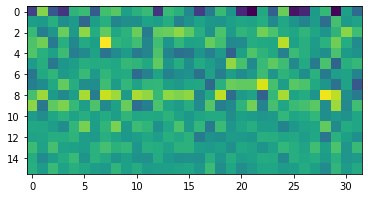

In [16]:
print(kernel_images.shape)

plt.imshow(kernel_images[0][0])

In [17]:
for dp in test_data:
    print(dp[1])

0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0


In [18]:

datapoint = test_data[len(test_data)-4]

img_data = np.asarray([dh.load_image(datapoint[0], resize=True, add_noise=False, randomly_rotate=False, grayscale=True)]).astype('uint8')

print("datapoint label: ", datapoint[1])
print("model prediction: ", model.predict(img_data))

all_layer_outputs = model.predict(img_data)

datapoint label:  1.0
model prediction:  [[2.8805378e-05]]


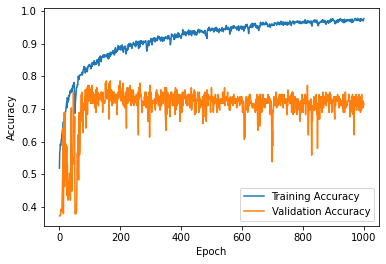

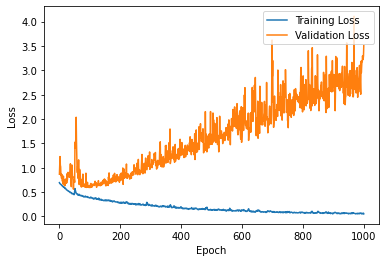

In [19]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy','Validation Accuracy'], loc='lower right')
plt.savefig('finetuned_acc_epoch_v1(c2d1).png', transparent= True, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper right')
plt.savefig('finetuned_loss_epoch_v1(c2d1).png', transparent= True, bbox_inches= 'tight', dpi= 900)
plt.show()


input_1 (1, 299, 299, 3) 


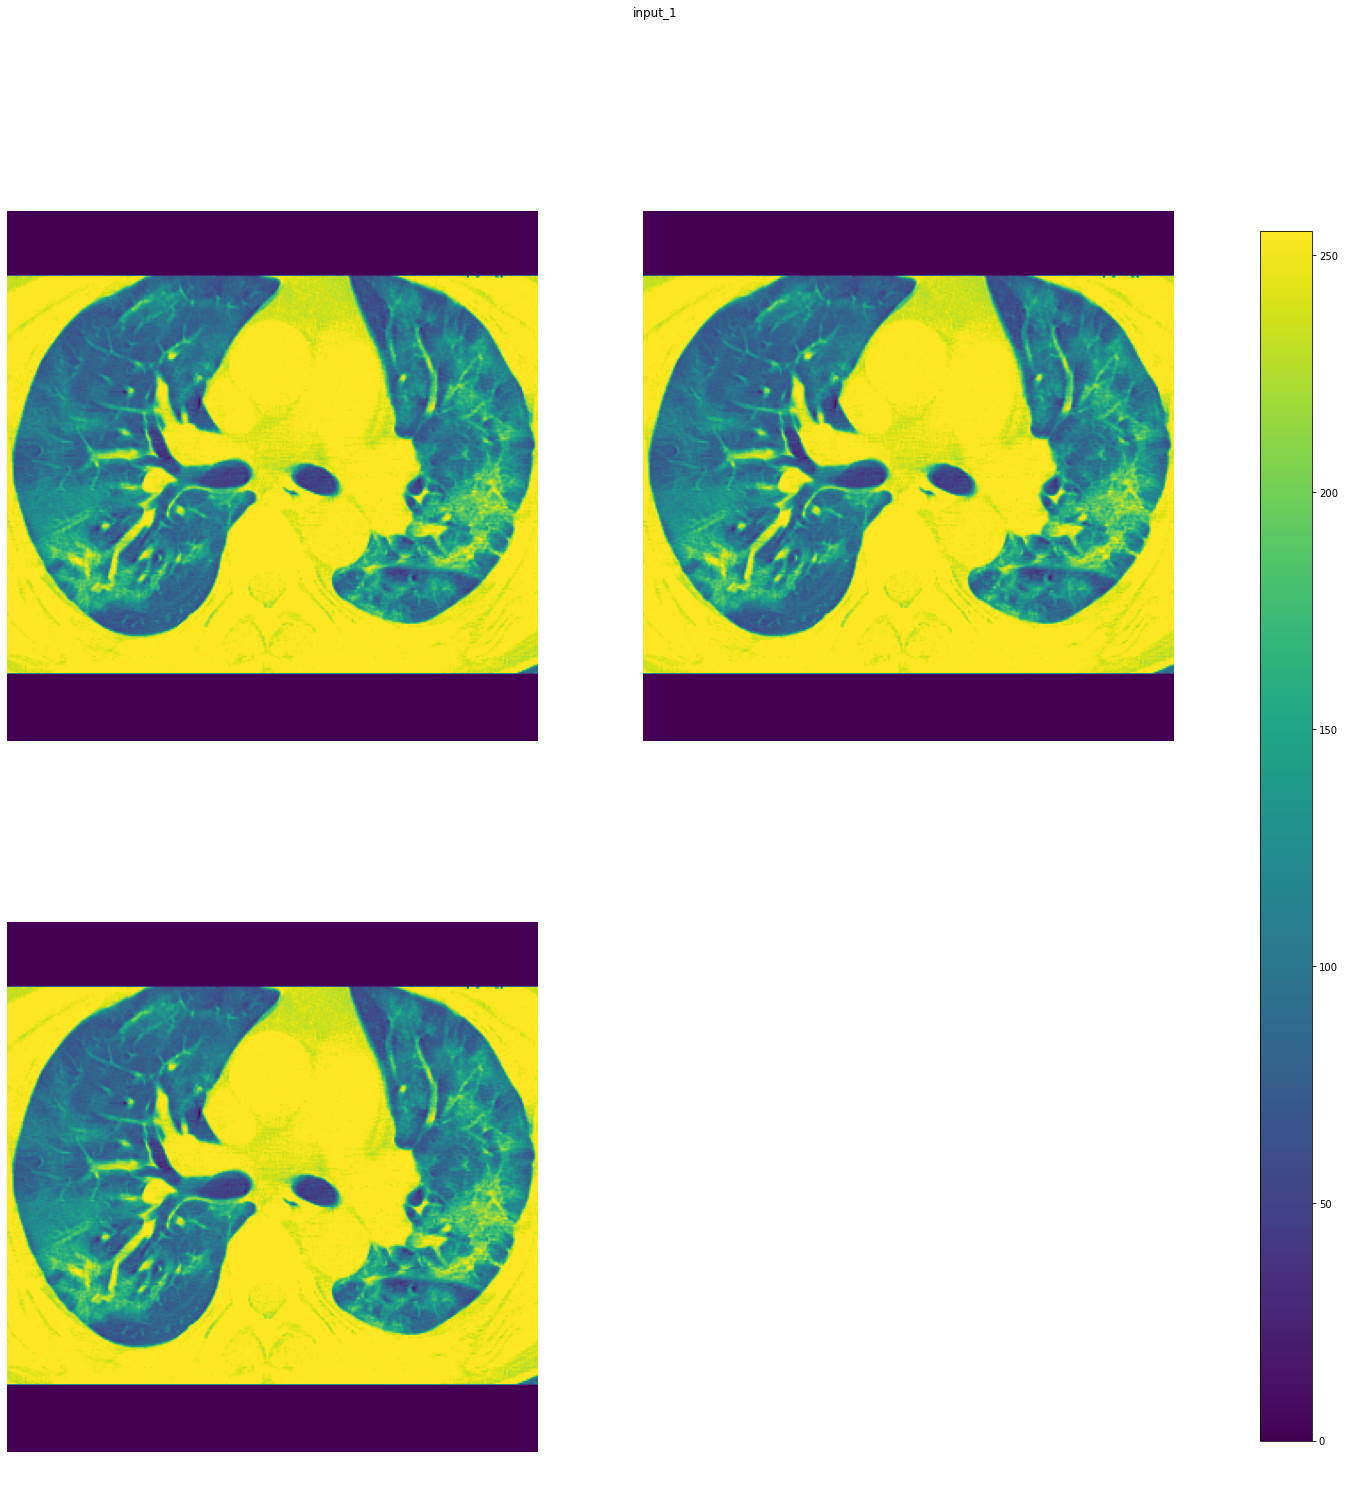

conv2d (1, 74, 74, 16) 


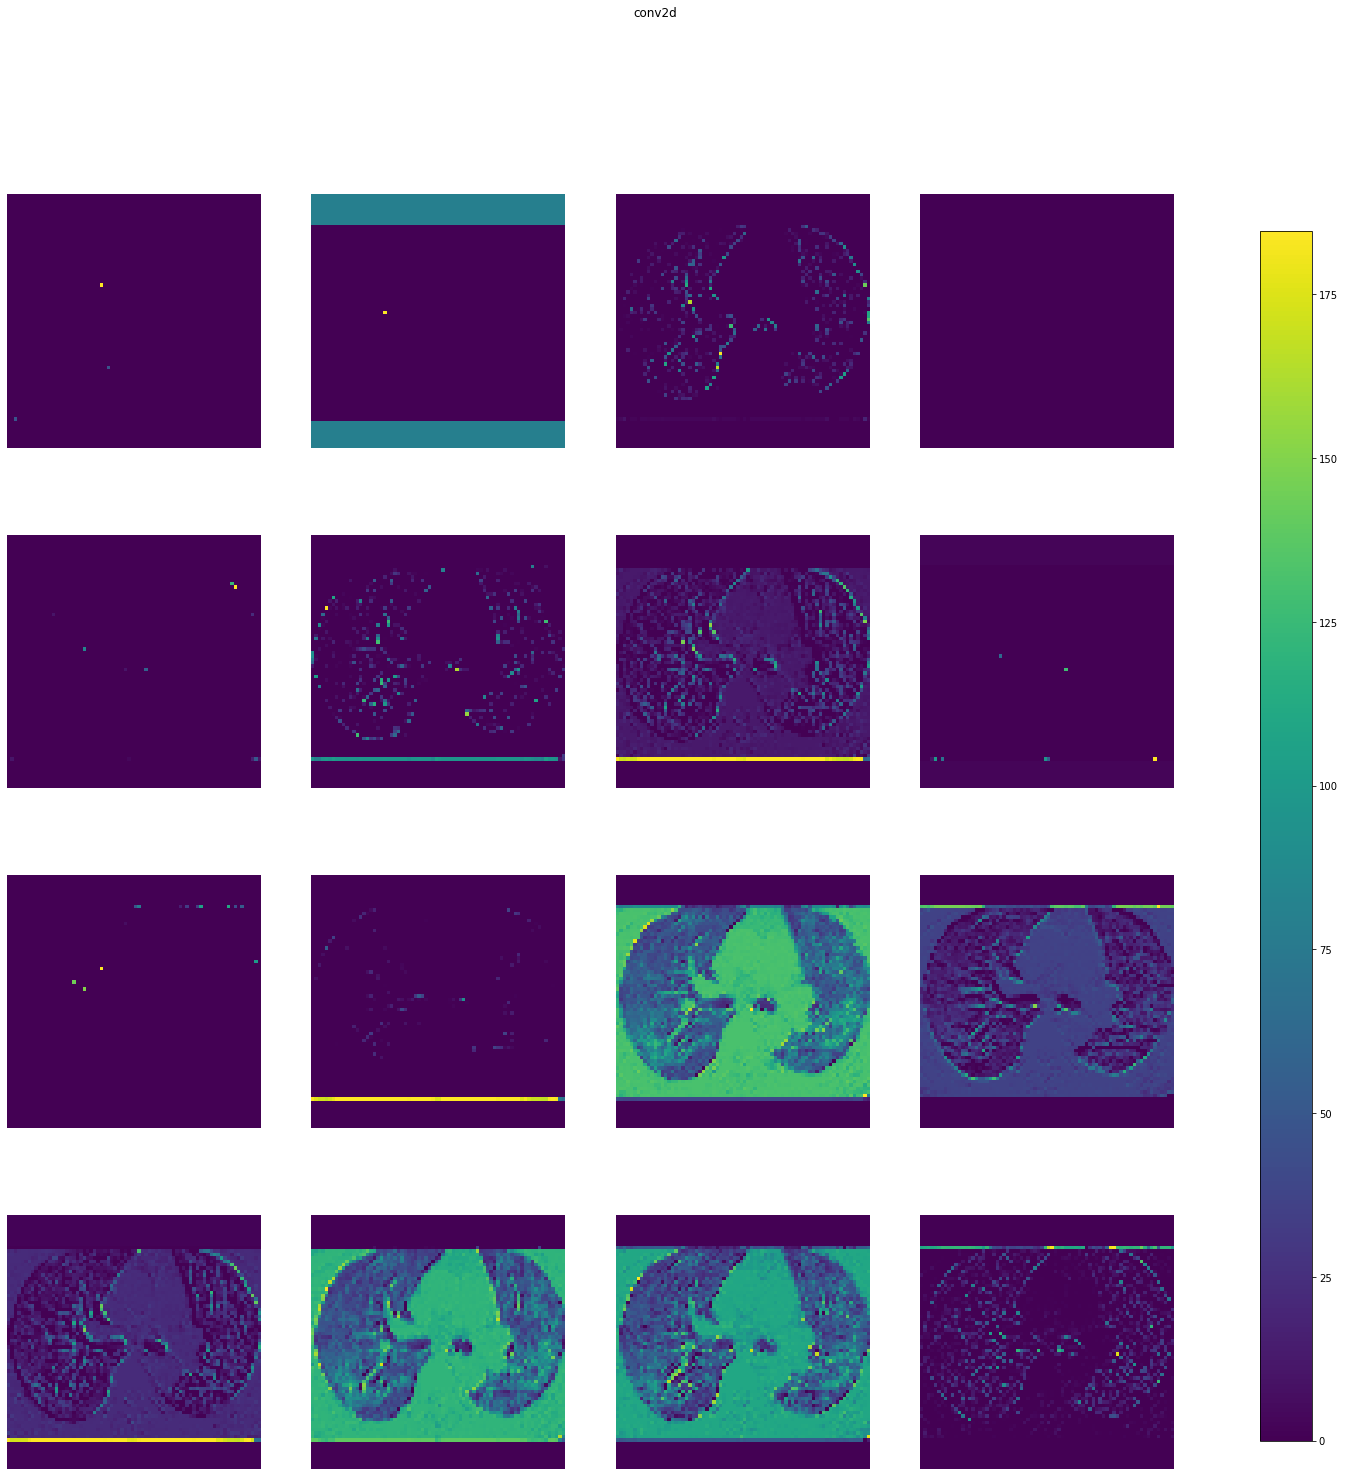

batch_normalization (1, 74, 74, 16) 


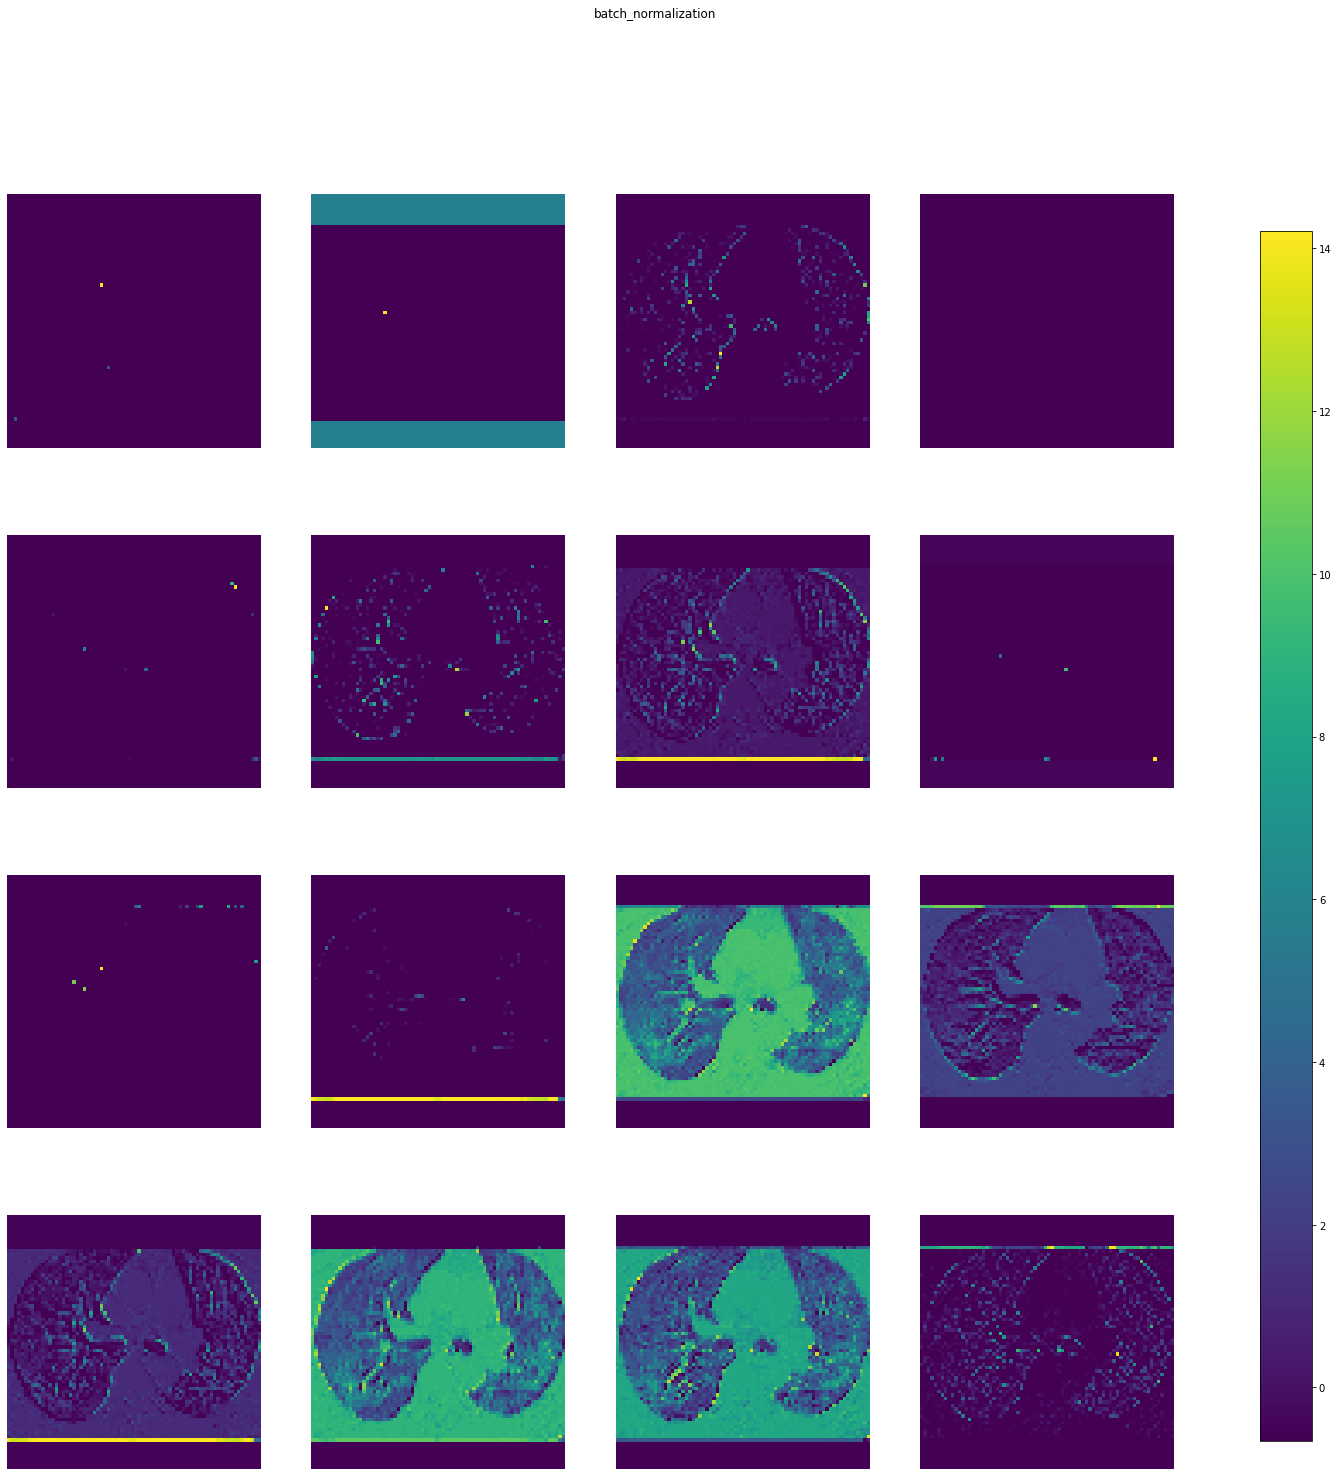

conv2d_1 (1, 24, 24, 32) 


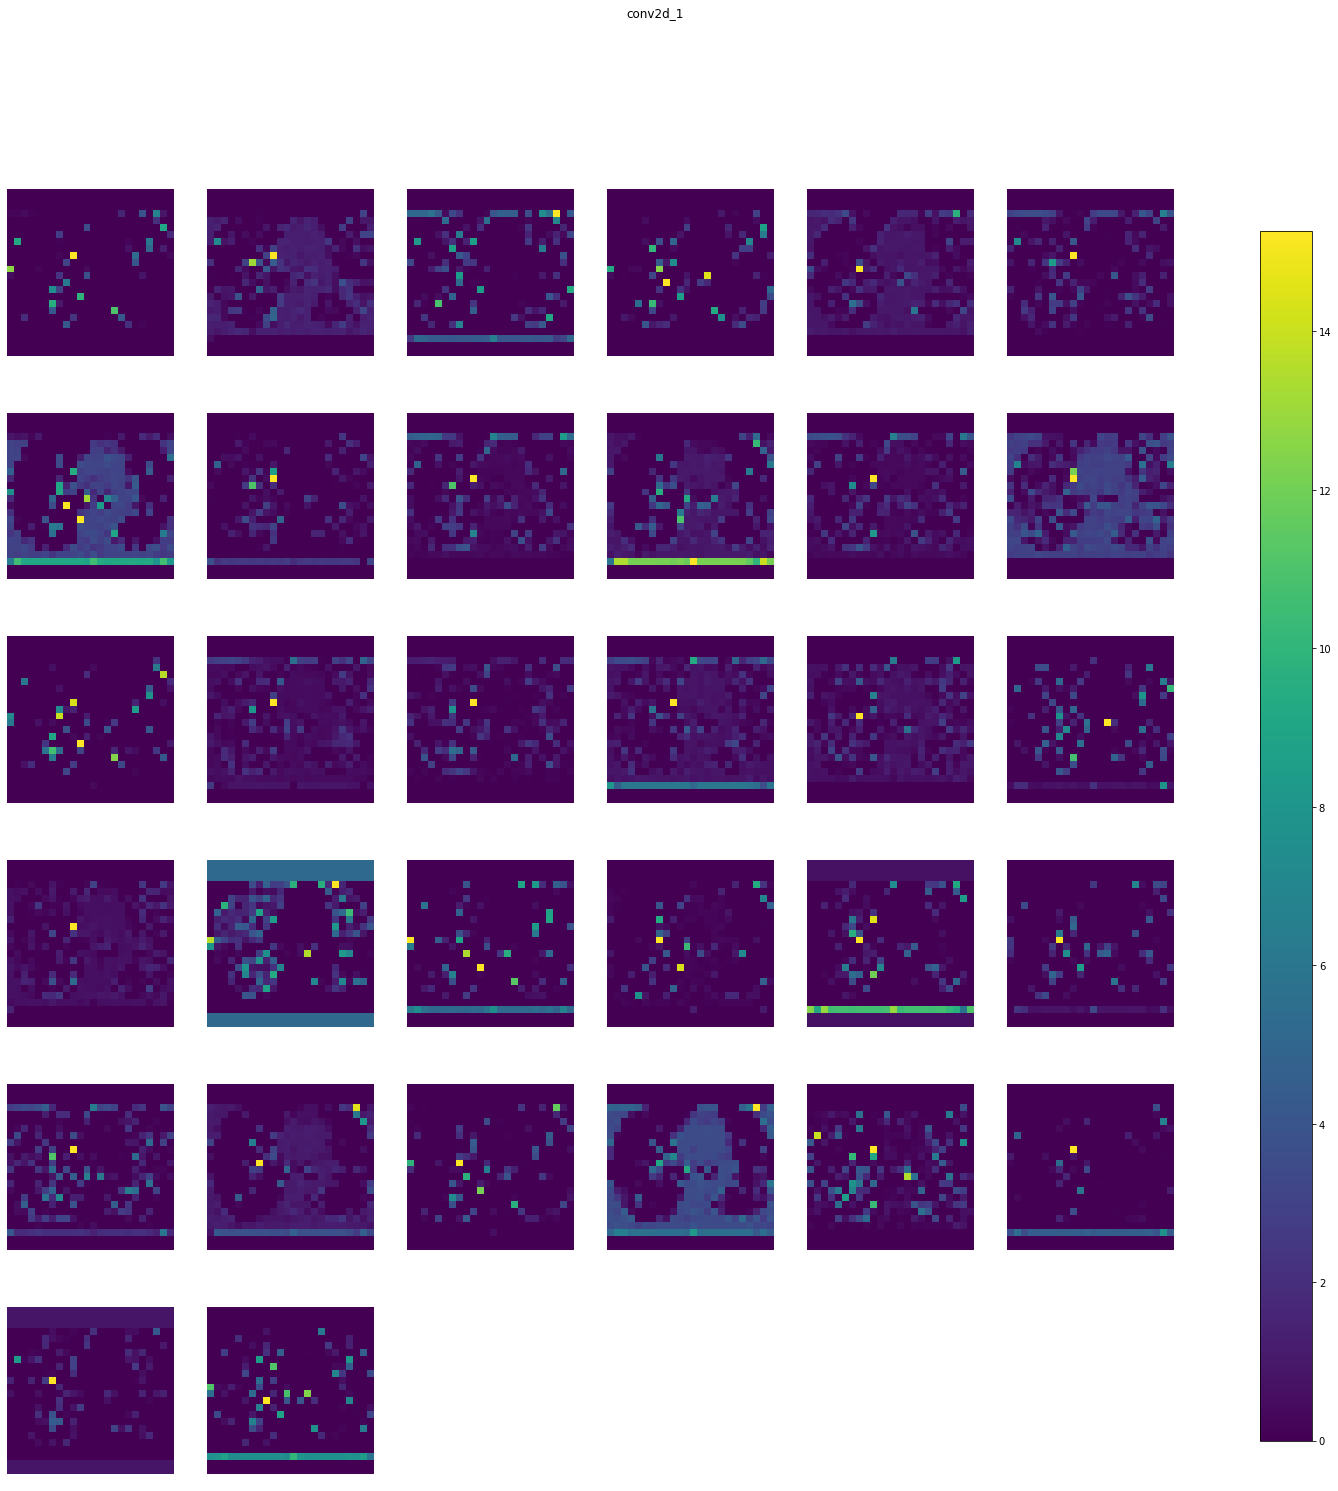

dropout (1, 24, 24, 32) 


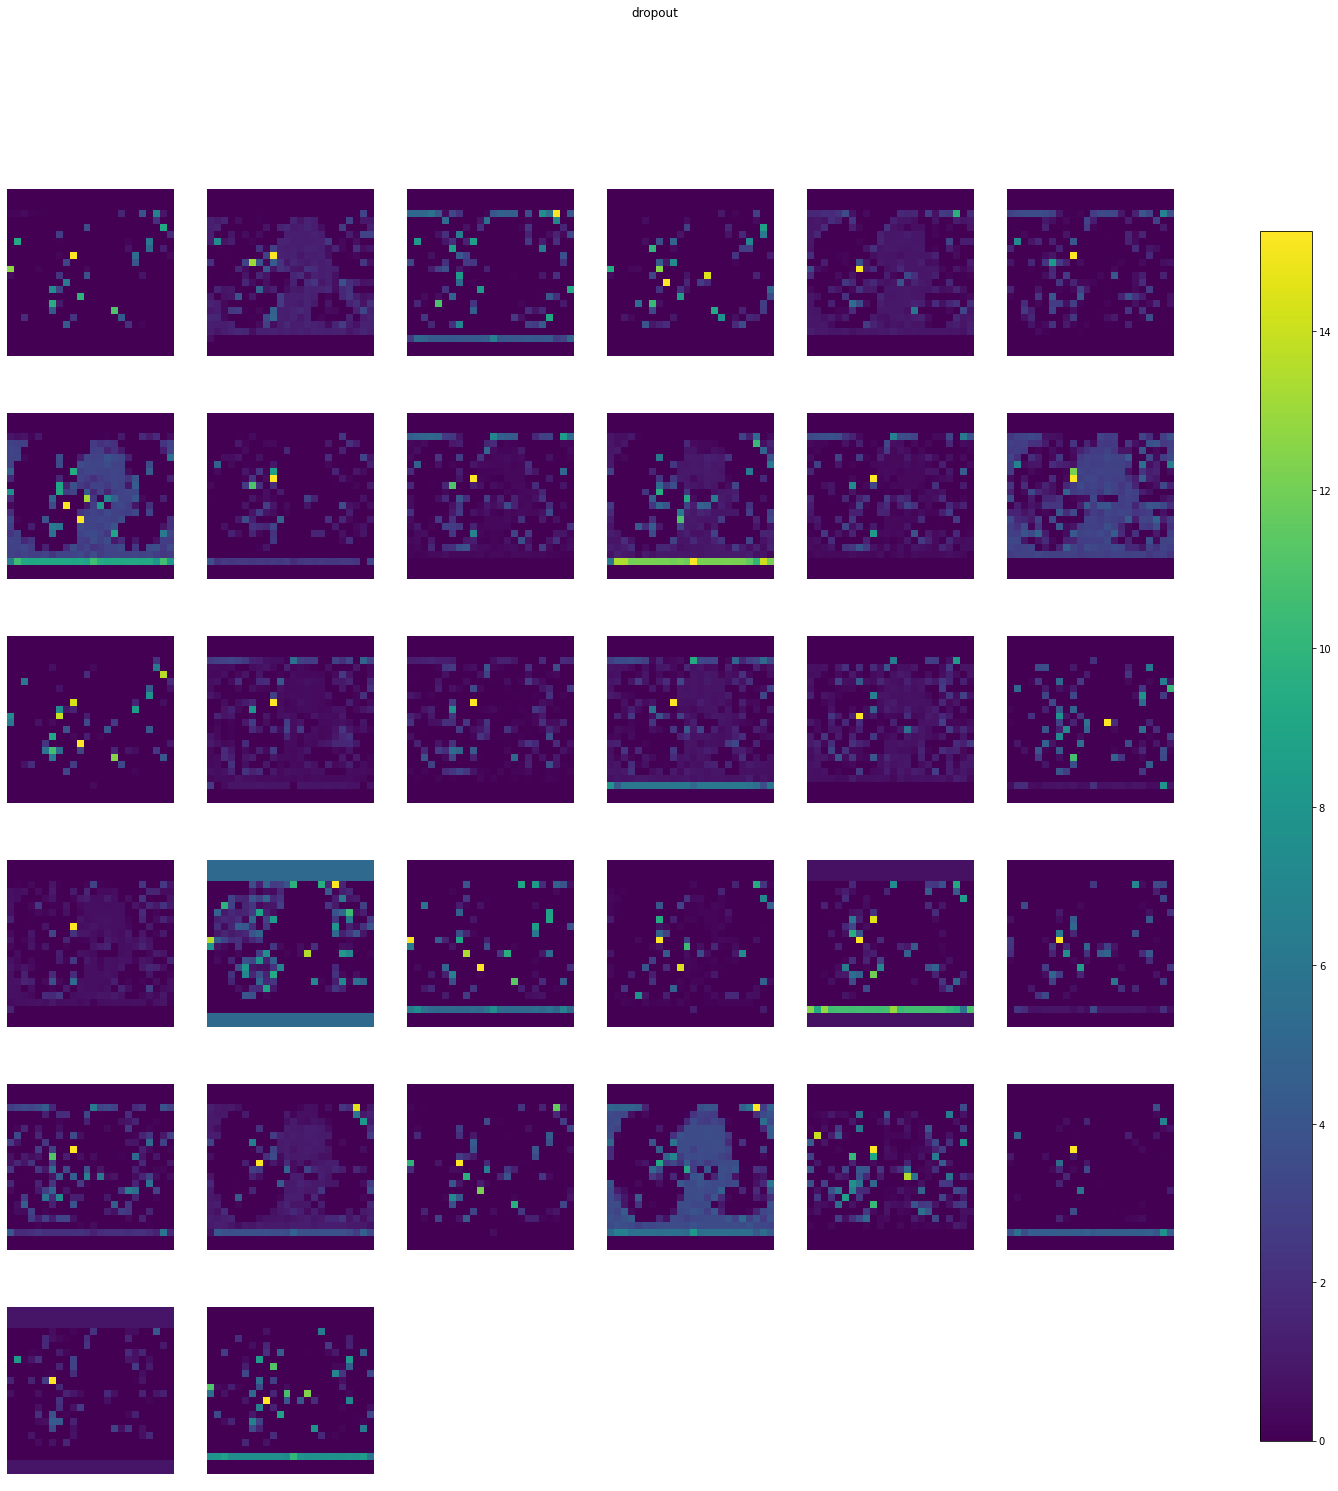

global_average_pooling2d (1, 32) 


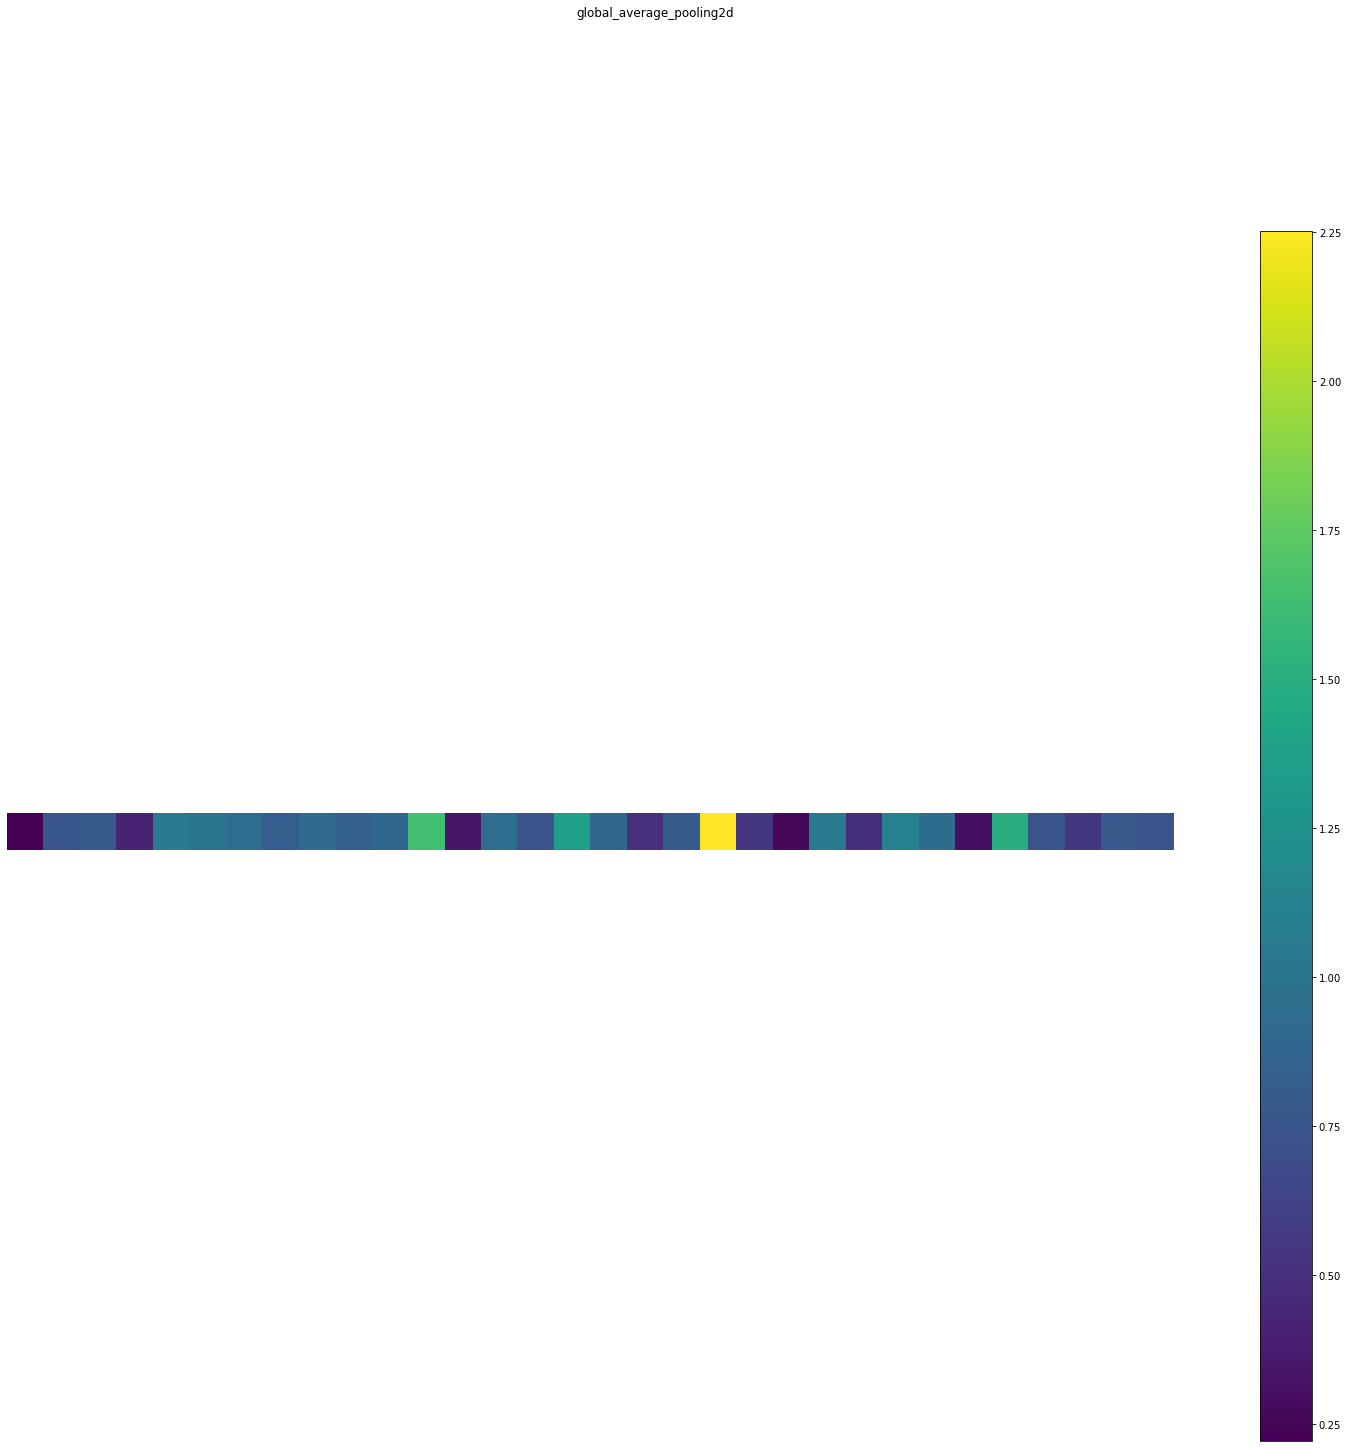

dense (1, 16) 


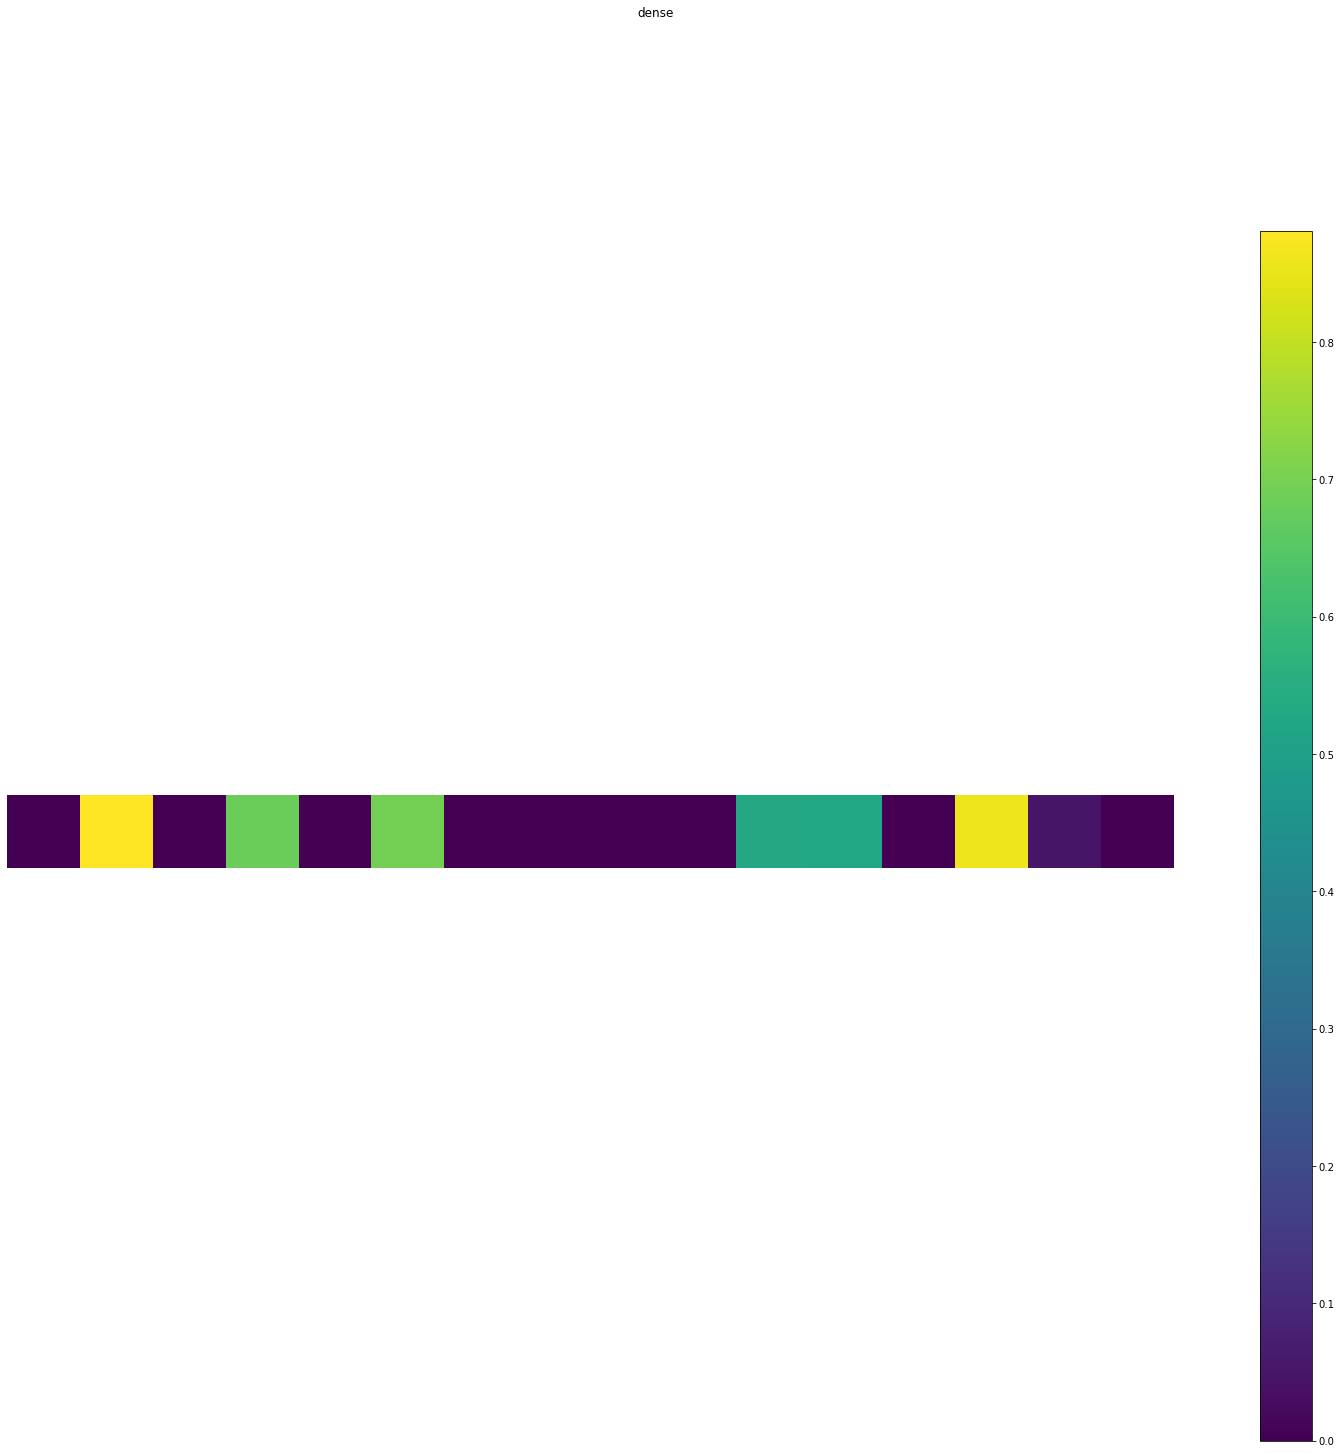

dropout_1 (1, 16) 


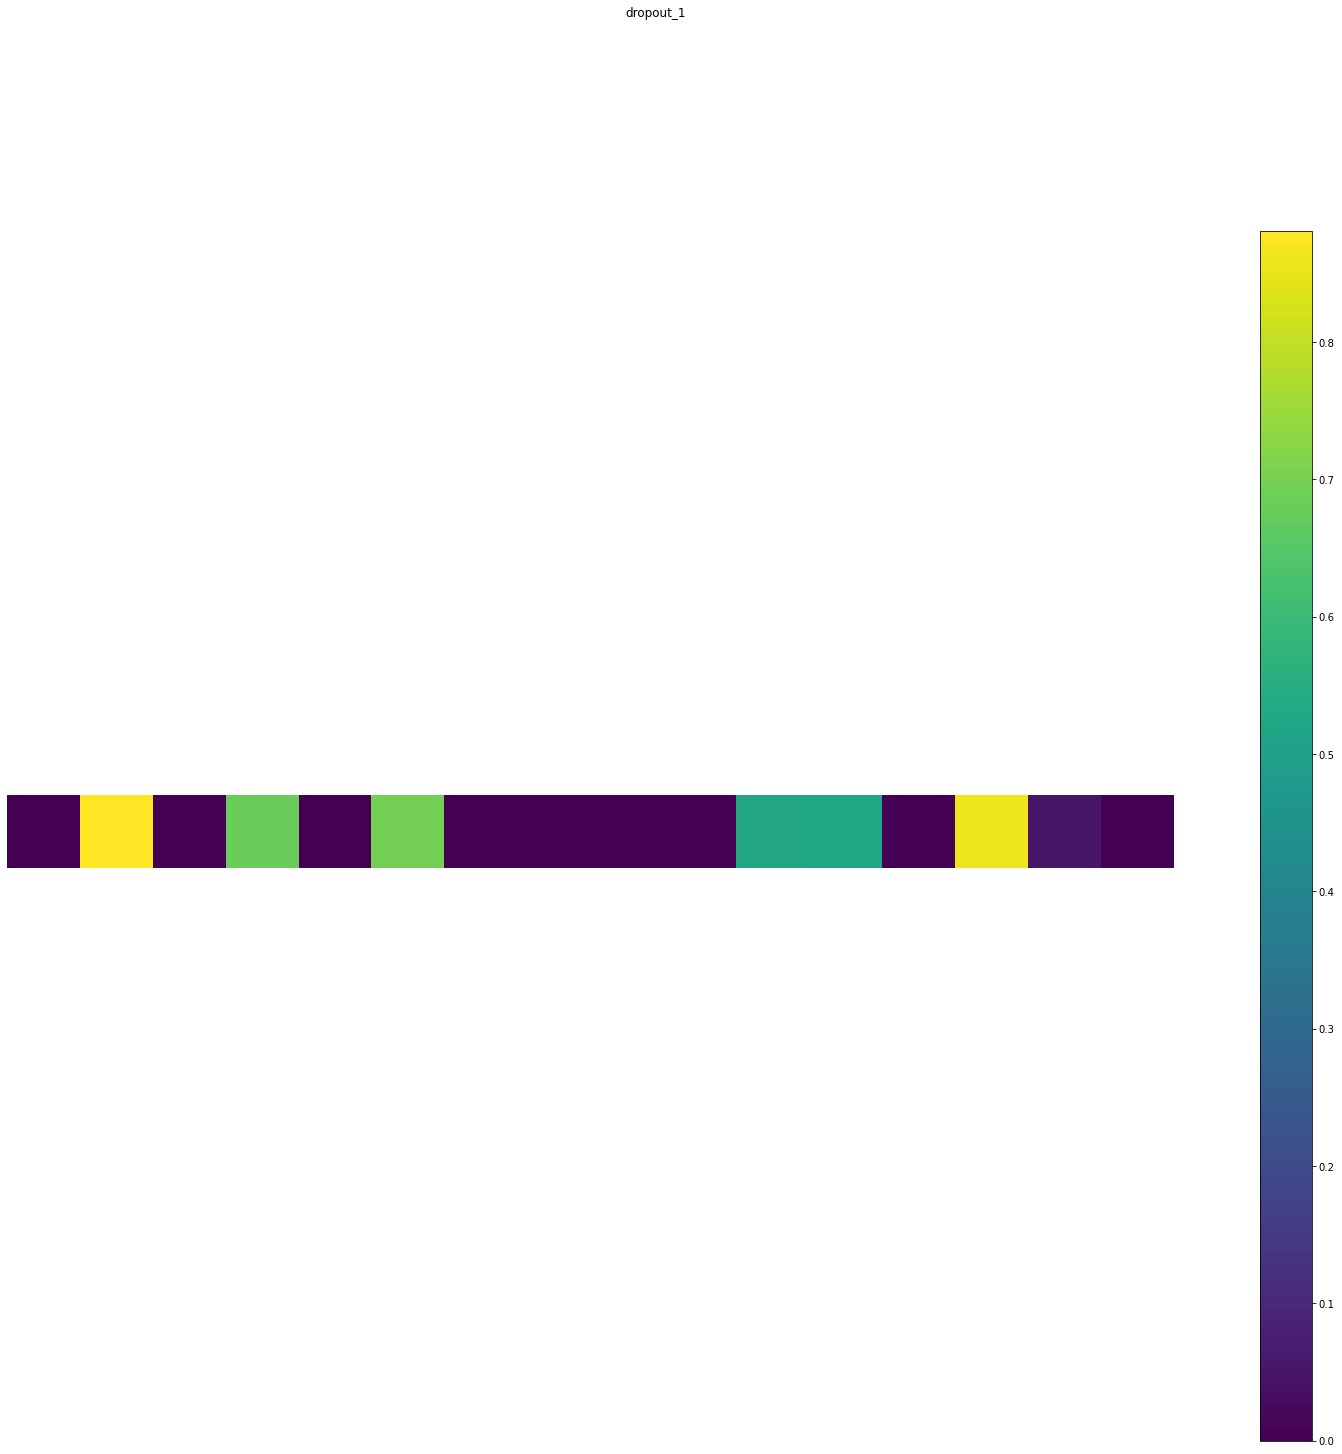

dense_1 (1, 1) 


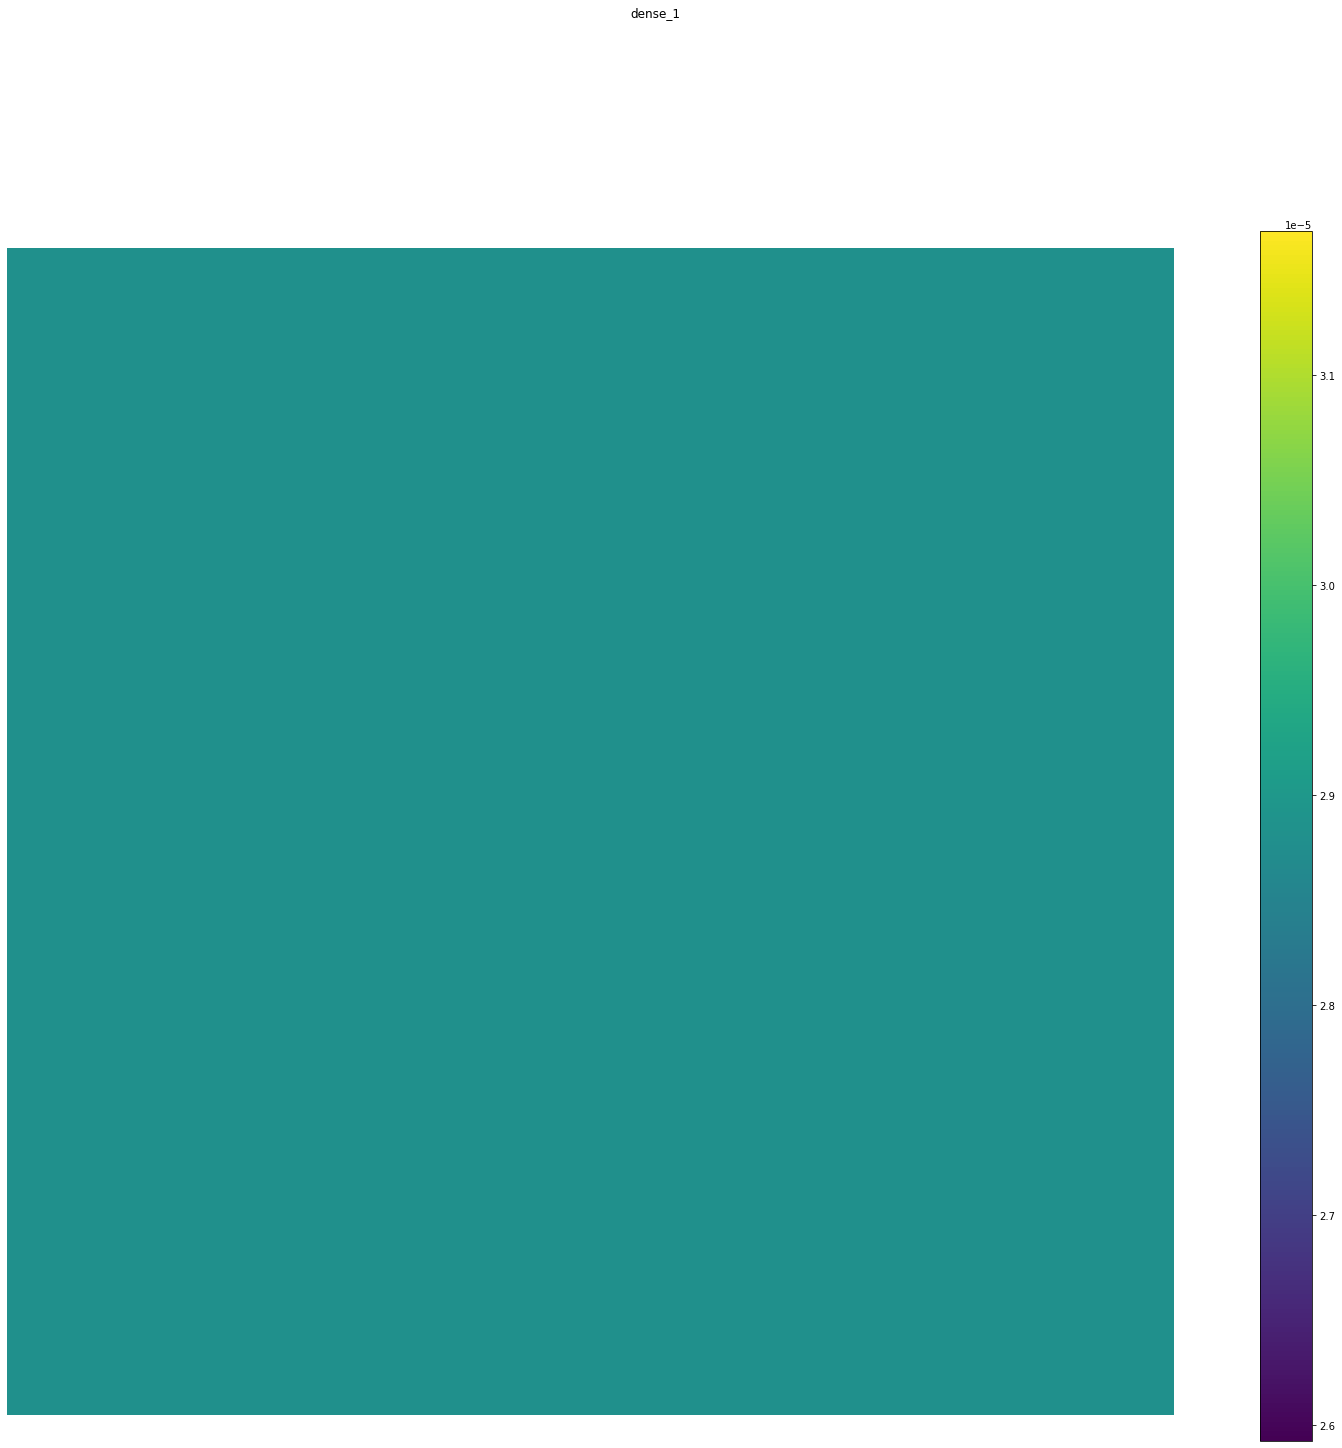

In [20]:
activations= keract.get_activations(model, img_data, layer_names= None, nodes_to_evaluate= None, output_format= 'simple', auto_compile= True)
keract.display_activations(activations, save= False)

In [21]:
layer_0_conv_out = all_layer_outputs[0]
layer_0_conv_out.shape
print("Layer Shape:",layer_0_conv_out.shape)

Layer Shape: (1,)


Input image shape: (1, 299, 299, 3)
[[0.55271655]]


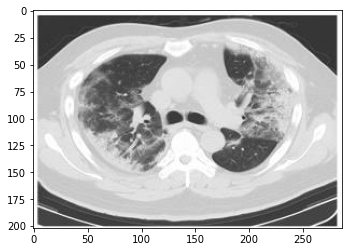

In [24]:
from matplotlib.pyplot import imread, imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
img_path = './2020.02.10.20021584-p6-52%9.png'
img = image.load_img(img_path, target_size=(299, 299,3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = imread(img_path)
imshow(my_image)
print(model.predict(x))